In [2]:
# Libraries and helper functions

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image

import numpy as np
from itertools import product
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from qutip import *
from qutip.piqs import *

from scipy.optimize import minimize_scalar
from scipy.stats import linregress

# The helper file below brings functions created in previous tutorials and adds an extra one
# make_df_for_energy_scan - we made this in tutorial 4
# make_braket_labels - we made this in tutorial 4
# simulate - we made this in tutorial 4
# plot_prob - made from code used for plotting in tutorial 4
# prettify_states - nice way to display many QuTiP states for side by side comparison
# 
from libs.helper_05_tutorial import *

from itertools import combinations


In [2]:
H_latex = "$H = (\Delta E_1 /2) \sigma_{z1} + (\Delta E_2 /2) \sigma_{z2} + \hbar\omega(a^{{\dagger}}a +1/2) + U( a^{{\dagger}} + a )(\sigma_{x1} +\sigma_{x2} )$ "

In [3]:
omega = 1

In [4]:
U = 0.01

In [5]:
parity = -1

In [6]:
max_bosons = 2

In [7]:
def make_operators(max_bosons, parity=0):
    a     = tensor(destroy(max_bosons+1), qeye(2), qeye(2))     # tensorised boson destruction operator
    sx1   = tensor(qeye(max_bosons+1), sigmax(), qeye(2))       # tensorised 𝜎𝑥1 operator 
    sx2   = tensor(qeye(max_bosons+1), qeye(2), sigmax())       # tensorised 𝜎𝑥2 operator 
    sz1   = tensor(qeye(max_bosons+1), sigmaz(), qeye(2))       # tensorised 𝜎z1 operator 
    sz2   = tensor(qeye(max_bosons+1), qeye(2), sigmaz())       # tensorised 𝜎z2 operator 
    J     = jspin(2, basis="uncoupled")
    Jx    = tensor(qeye(max_bosons+1), J[0])                               # tensorised Jx operator
    Jz    = tensor(qeye(max_bosons+1), J[2])                               # tensorised Jx operator
    J2    = tensor(qeye(max_bosons+1), J[0]*J[0] + J[1]*J[1] + J[2]*J[2])  # tensorised J^2 operator
    
    two_state_1     =  1/2*sz1                                  # two state system energy operator   𝜎𝑧1/2
    two_state_2     =  1/2*sz2                                  # two state system energy operator   𝜎𝑧2/2
    bosons          = (a.dag()*a+0.5)                           # boson energy operator              𝑎†𝑎+1/2
    number          = a.dag()*a                                 # boson number operator              𝑎†𝑎
    interaction_1   = (a.dag() + a) * sx1                       # interaction energy operator       (𝑎†+𝑎)𝜎𝑥1  
    interaction_2   = (a.dag() + a) * sx2                       # interaction energy operator       (𝑎†+𝑎)𝜎𝑥2  
    
    P = sz1*sz2*(1j*np.pi*number).expm()                        # parity operator 
    
    # map from QuTiP number states to |n,±, ±> states
    possible_ns = range(0, max_bosons+1)
    possible_ms = ["+","-"]
    nmm_list = [(n,m1,m2) for (n,m1,m2) in product(possible_ns, possible_ms, possible_ms)]
    
    # only do parity extraction if a valid parity is being used
    if (parity==1) | (parity==-1):
        p           = np.where(P.diag()==parity)[0]
    
        two_state_1     = two_state_1.extract_states(p)
        two_state_2     = two_state_2.extract_states(p)
        bosons          = bosons.extract_states(p)
        number          = number.extract_states(p)
        interaction_1   = interaction_1.extract_states(p)
        interaction_2   = interaction_2.extract_states(p)
        P               = P.extract_states(p)
        J2              = J2.extract_states(p)
        nmm_list        = [nmm_list[i] for i in p]

    return two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nmm_list



In [8]:
two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nmm_list = make_operators(max_bosons=max_bosons, parity=parity)

In [9]:
# prepare data structure for the energy level scan
df_even = make_df_for_energy_scan("$\Delta E$", 0, 200, 2001, two_state_1.shape[0])

for i, row in df_even.iterrows():
    H =  row["$\Delta E$"]*two_state_1+ row["$\Delta E$"]*two_state_2 + omega*bosons + U*interaction_1 + U*interaction_2
    evals, ekets = H.eigenstates()
    df_even.iloc[i,1:] = evals 

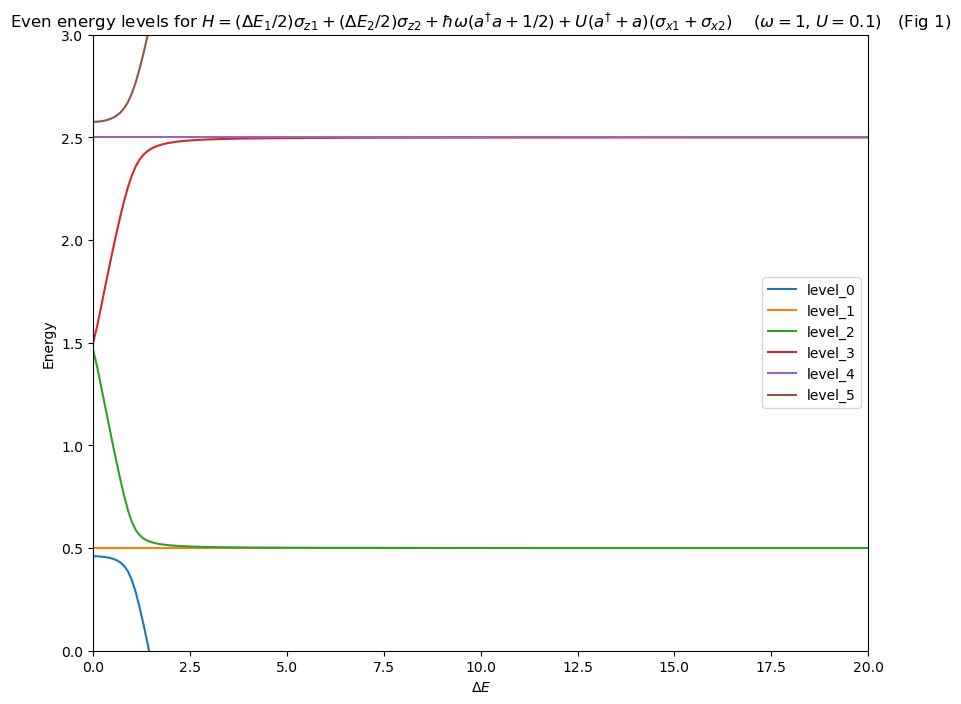

In [10]:
df_even.plot(x="$\Delta E$",ylim=[0,3],xlim=[0,20], legend=True, 
        title=f"Even energy levels for {H_latex}   ($\omega={omega}$, $U={U}$)   (Fig 1)",
             figsize=(10,8));

plt.ylabel("Energy");


In [292]:
two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nmm_list = make_operators(max_bosons=max_bosons, parity=-1)

In [112]:
U = 0.01

In [113]:
H = 1*two_state_1 + 1*two_state_2 + omega*bosons + U*interaction_1 + U*interaction_2

In [293]:
nmm_list

[(0, '+', '-'),
 (0, '-', '+'),
 (1, '+', '+'),
 (1, '-', '-'),
 (2, '+', '-'),
 (2, '-', '+')]

In [115]:
psi0 = basis(len(nmm_list), 0)
times = np.linspace(0.0, 1000, 10000)
P, psi = simulate(H, psi0, times)

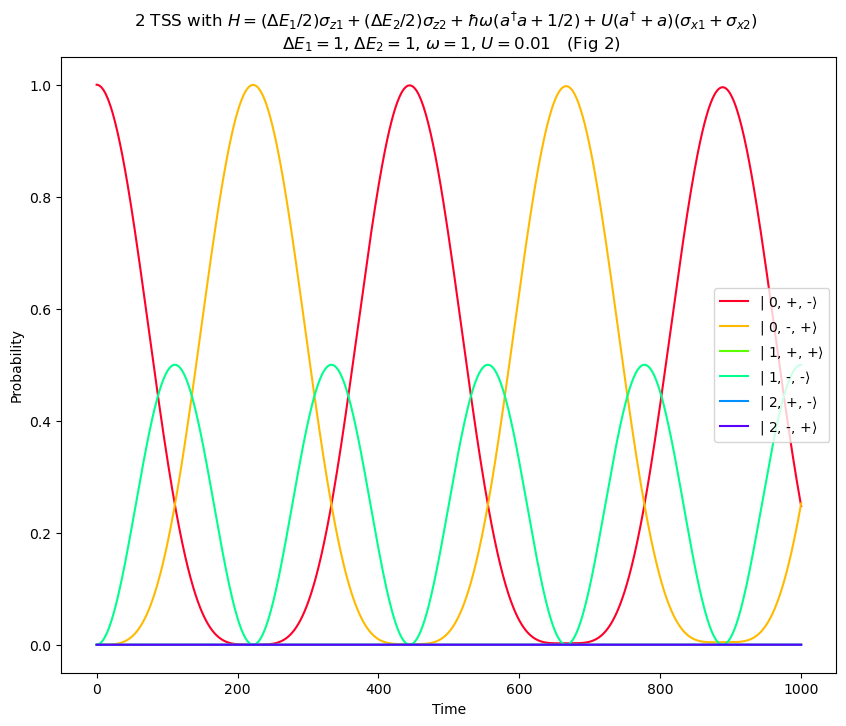

In [116]:
bra_labels, ket_labels = make_braket_labels(nmm_list)
plot_prob(P ,times, ket_labels)
plt.title(f"2 TSS with {H_latex} \n $\Delta E_1 = 1$, $\Delta E_2 = 1$, $\omega={omega}$, $U={U}$   (Fig 2)");

In [56]:
H = 1*two_state_1 + 1*two_state_2 + omega*bosons + U*interaction_1 + U*interaction_2

In [57]:
psi0 = basis(len(nmm_list), 0) + basis(len(nmm_list), 1)
psi0 = psi0.unit()

In [58]:
times = np.linspace(0.0, 1000, 10000)
P, psi = simulate(H, psi0, times)

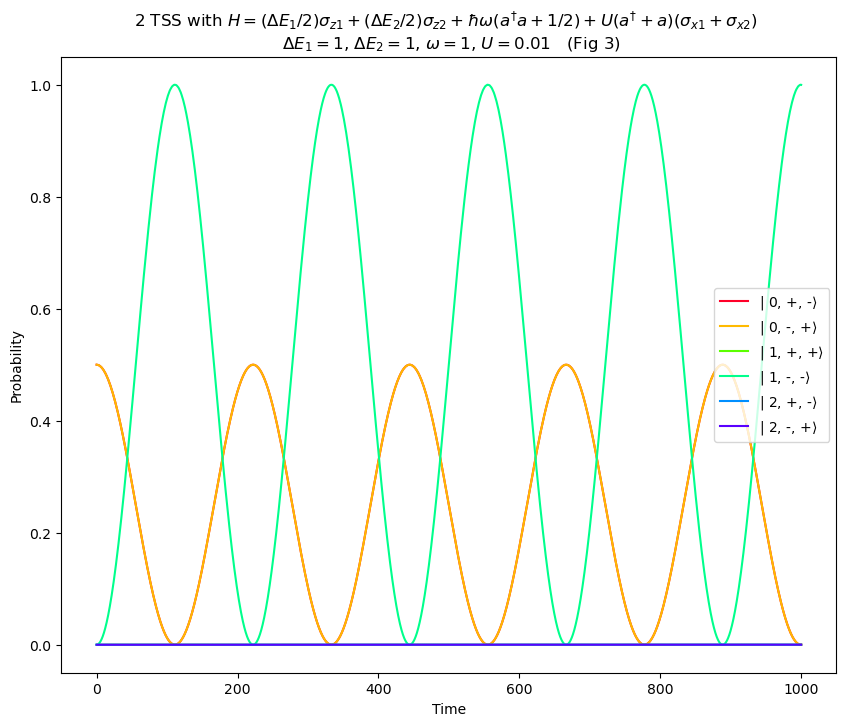

In [59]:
bra_labels, ket_labels = make_braket_labels(nmm_list)
plot_prob(P ,times, ket_labels)
plt.title(f"2 TSS with {H_latex} \n $\Delta E_1 = 1$, $\Delta E_2 = 1$, $\omega={omega}$, $U={U}$   (Fig 3)");

In [63]:
def make_operators_one(max_bosons, parity=0):
    
    a       = tensor(destroy(max_bosons+1), qeye(2))     # tensorised boson destruction operator
    number  = tensor(num(max_bosons+1), qeye(2))         # tensorised boson number operator
    sx      = tensor(qeye(max_bosons+1), sigmax())       # tensorised sigma_x operator
    sz      = tensor(qeye(max_bosons+1),sigmaz())        # tensorised sigma_z operator
    
    two_state     =  1/2*sz                              # two state system energy operator
    bosons       =  (number+0.5)                         # boson energy operator
    interaction  = (a.dag() + a) * sx                    # interaction energy operator      
    
    P = sz*(1j*np.pi*number).expm()                      # parity operator 
    
    # map from QuTiP number states to |n,±> states
    possible_ns = range(0, max_bosons+1)
    possible_ms = ["+","-"]
    nm_list = [(n,m) for (n,m) in product(possible_ns, possible_ms)]
    
    # only do parity extraction if a valid parity is being used
    if (parity==1) | (parity==-1):
        p           = np.where(P.diag()==parity)[0]
        
        two_state   = two_state.extract_states(p)
        bosons      = bosons.extract_states(p)
        number      = number.extract_states(p)
        interaction = interaction.extract_states(p)
        nm_list     = [nm_list[i] for i in p]
    
    
    return two_state, bosons, interaction, number, nm_list

In [64]:
two_state, bosons, interaction, number, nm_list = make_operators_one(max_bosons=2, parity=1)

In [65]:
H = 1*two_state  + omega*bosons + U*interaction

In [66]:
nm_list

[(0, '+'), (1, '-'), (2, '+')]

In [7]:
H_latex_one = "$H = (\Delta E /2) \sigma_{z}  + \hbar\omega(a^{{\dagger}}a +1/2) + U( a^{{\dagger}} + a )\sigma_{x}$ "

In [68]:
psi0 = basis(len(nm_list), 0)
times = np.linspace(0.0, 1000, 10000)
P, psi = simulate(H, psi0, times)

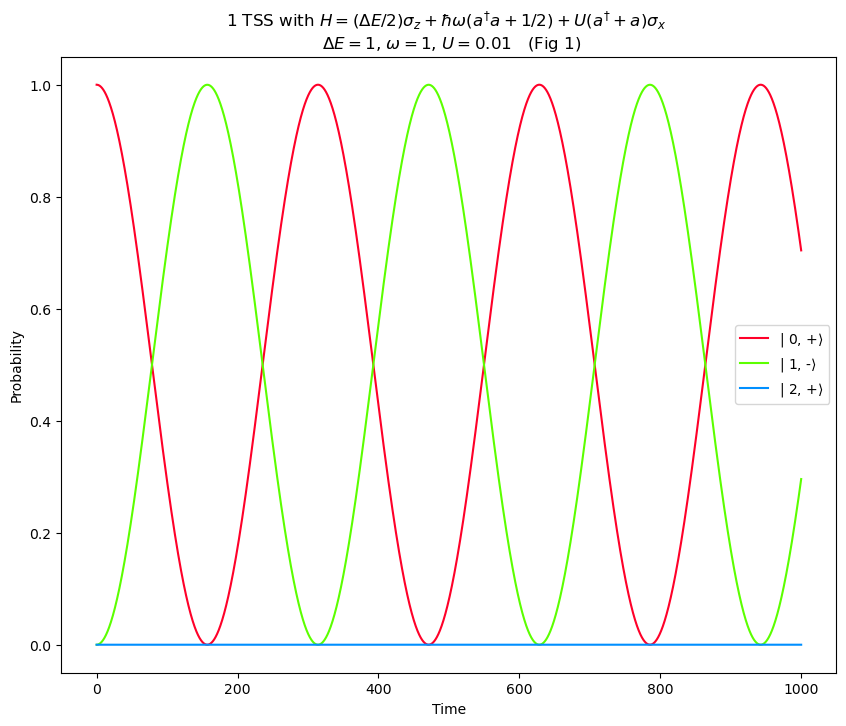

In [69]:
bra_labels, ket_labels = make_braket_labels(nm_list)
plot_prob(P ,times, ket_labels)
plt.title(f"1 TSS with {H_latex_one} \n $\Delta E = 1$, $\omega={omega}$, $U={U}$   (Fig 1)");

In [815]:
def make_operators_four(max_bosons, parity=0):
    a     = tensor(destroy(max_bosons+1), qeye(2), qeye(2),qeye(2), qeye(2))     # tensorised boson destruction operator
    sx1   = tensor(qeye(max_bosons+1), sigmax(), qeye(2),qeye(2), qeye(2))       # tensorised 𝜎𝑥1 operator 
    sx2   = tensor(qeye(max_bosons+1), qeye(2), sigmax(),qeye(2), qeye(2))       # tensorised 𝜎𝑥2 operator
    sx3   = tensor(qeye(max_bosons+1), qeye(2), qeye(2),sigmax(), qeye(2))       # tensorised 𝜎𝑥3 operator
    sx4   = tensor(qeye(max_bosons+1), qeye(2), qeye(2), qeye(2),sigmax())     # tensorised 𝜎𝑥4 operator
    sz1   = tensor(qeye(max_bosons+1), sigmaz(), qeye(2),qeye(2), qeye(2))       # tensorised 𝜎z1 operator 
    sz2   = tensor(qeye(max_bosons+1), qeye(2), sigmaz(),qeye(2), qeye(2))       # tensorised 𝜎z2 operator 
    sz3   = tensor(qeye(max_bosons+1), qeye(2), qeye(2),sigmaz(), qeye(2))       # tensorised 𝜎z2 operator 
    sz4   = tensor(qeye(max_bosons+1), qeye(2), qeye(2),qeye(2), sigmaz())       # tensorised 𝜎z2 operator 
    J     = jspin(4, basis="uncoupled")
    Jx    = tensor(qeye(max_bosons+1), J[0])                               # tensorised Jx operator
    Jz    = tensor(qeye(max_bosons+1), J[2])                               # tensorised Jx operator
    J2    = tensor(qeye(max_bosons+1), J[0]*J[0] + J[1]*J[1] + J[2]*J[2])  # tensorised J^2 operator
    
    two_state_1     =  1/2*sz1                                  # two state system energy operator   𝜎𝑧1/2
    two_state_2     =  1/2*sz2                                  # two state system energy operator   𝜎𝑧2/2
    two_state_3     =  1/2*sz3                                  # two state system energy operator   𝜎𝑧2/2
    two_state_4     =  1/2*sz4                                  # two state system energy operator   𝜎𝑧2/2
    bosons          = (a.dag()*a+0.5)                           # boson energy operator              𝑎†𝑎+1/2
    number          = a.dag()*a                                 # boson number operator              𝑎†𝑎
    interaction_1   = (a.dag() + a) * sx1                       # interaction energy operator       (𝑎†+𝑎)𝜎𝑥1  
    interaction_2   = (a.dag() + a) * sx2                       # interaction energy operator       (𝑎†+𝑎)𝜎𝑥2 
    interaction_3   = (a.dag() + a) * sx3                       # interaction energy operator       (𝑎†+𝑎)𝜎𝑥2 
    interaction_4   = (a.dag() + a) * sx4                       # interaction energy operator       (𝑎†+𝑎)𝜎𝑥2 
    
    P = sz1*sz2*sz3*sz4*(1j*np.pi*number).expm()                        # parity operator 
    
    # map from QuTiP number states to |n,±, ±> states
    possible_ns = range(0, max_bosons+1)
    possible_ms = ["+","-"]
    nmm_list = [(n,m1,m2,m3,m4) for (n,m1,m2,m3,m4) in product(possible_ns, possible_ms, possible_ms,possible_ms,possible_ms)]
    
    # only do parity extraction if a valid parity is being used
    if (parity==1) | (parity==-1):
        p           = np.where(P.diag()==parity)[0]
    
        two_state_1     = two_state_1.extract_states(p)
        two_state_2     = two_state_2.extract_states(p)
        two_state_3     = two_state_3.extract_states(p)
        two_state_4     = two_state_4.extract_states(p)
        bosons          = bosons.extract_states(p)
        number          = number.extract_states(p)
        interaction_1   = interaction_1.extract_states(p)
        interaction_2   = interaction_2.extract_states(p)
        interaction_3   = interaction_3.extract_states(p)
        interaction_4   = interaction_4.extract_states(p)
        P               = P.extract_states(p)
        J2              = J2.extract_states(p)
        nmm_list        = [nmm_list[i] for i in p]

    return two_state_1, two_state_2, two_state_3, two_state_4, bosons, interaction_1, interaction_2, interaction_3, interaction_4, number, nmm_list, P



In [816]:
two_state_1, two_state_2, two_state_3, two_state_4, bosons, interaction_1, interaction_2,interaction_3, interaction_4, number, nmm_list, P= make_operators_four(max_bosons=2, parity=-1)

In [817]:
H = 2.5*two_state_1 + 2.5*two_state_2 +2.5*two_state_3+2.5*two_state_4 + omega*bosons + U*interaction_1 + U*interaction_2 + U*interaction_3 + U*interaction_4

In [818]:
# psi0 = basis(len(nmm_list), 1) + basis(len(nmm_list), 2) +  basis(len(nmm_list), 3) +  basis(len(nmm_list), 4) +  basis(len(nmm_list), 5) +  basis(len(nmm_list), 6)
# psi0 = psi0.unit()

In [823]:
nmm_list[3],nmm_list[5]


((0, '+', '-', '-', '-'), (0, '-', '+', '-', '-'))

In [824]:
psi0 = basis(len(nmm_list), 3) + basis(len(nmm_list), 5)
psi0 = psi0.unit()

In [825]:
times = np.linspace(0.0, 40000, 400000)
P, psi = simulate(H, psi0, times)

In [23]:
bra_labels, ket_labels = make_braket_labels(nmm_list)
plot_prob(P ,times, ket_labels)
plt.title(f"1 TSS with {H_latex_one} \n $\Delta E = 1$, $\omega={omega}$, $U={U}$   (Fig 1)");

NameError: name 'nmm_list' is not defined

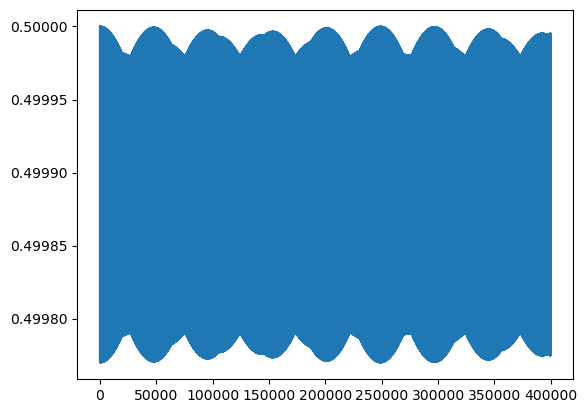

In [165]:
plt.plot(P[5,:])

In [7]:
def make_operators_J(max_bosons, parity=0, num_TLS=1):
    
    a     = tensor([destroy(max_bosons+1)] + [qeye(2) for i in range(1,num_TLS+1)])      # tensorised boson destruction operator
    J     = jspin(num_TLS, basis="uncoupled")
    Jx    = tensor(qeye(max_bosons+1), J[0])                                             # tensorised Jx operator
    Jz    = tensor(qeye(max_bosons+1), J[2])                                             # tensorised Jx operator
    J2    = tensor(qeye(max_bosons+1), J[0]*J[0] + J[1]*J[1] + J[2]*J[2])                # tensorised J^2 operator

    two_state     = Jz                                 # two state system energy operator   Jz
    bosons        = (a.dag()*a+0.5)                    # boson energy operator              𝑎†𝑎+1/2
    number        = a.dag()*a                          # boson number operator              𝑎†𝑎
    interaction   = 2*(a.dag() + a) * Jx               # interaction energy operator        2(𝑎†+𝑎)Jz  
    
    P = (1j*np.pi*(number + Jz + num_TLS/2)).expm()               # parity operator 
    
    # map from QuTiP number states to |n,±, ±, ...> states
    possible_ns = range(0, max_bosons+1)
    possible_ms = ["+","-"]
    nm_list = [(n, *ms) for n in possible_ns for ms in product(possible_ms, repeat=num_TLS)]
    # nm_list = [(n,m1,m2,m3,m4) for (n,m1,m2,m3,m4) in product(possible_ns, possible_ms, possible_ms,possible_ms,possible_ms)]

    
    # only do parity extraction if a valid parity is being used
    if (parity==1) | (parity==-1):
        p               = np.where(P.diag()==parity)[0]
        
        two_state       = two_state.extract_states(p)
        bosons          = bosons.extract_states(p)
        number          = number.extract_states(p)
        interaction     = interaction.extract_states(p)
        J2              = J2.extract_states(p)  
        nm_list        = [nm_list[i] for i in p]
  
    
    return two_state, bosons, interaction, number, nm_list, J2

In [8]:
from itertools import permutations

def generate_permutations(n_plus, n_minus):
    """Generate permutations of n_plus '+' characters and n_minus '-' characters."""

    if n_plus <=0:
        raise ValueError("n_plus must be positive.")

    if n_minus == 0:
        return ['+'] * n_plus
    
    chars = ['+'] * n_plus + ['-'] * n_minus
    
    # Get all unique permutations of the characters
    seen = set()
    for perm in permutations(chars, n_plus + n_minus):
        if perm not in seen:
            seen.add(perm)
    return list(seen)

### N<sub>A</sub> : N<sub>B</sub>,  1 TLS excited in A

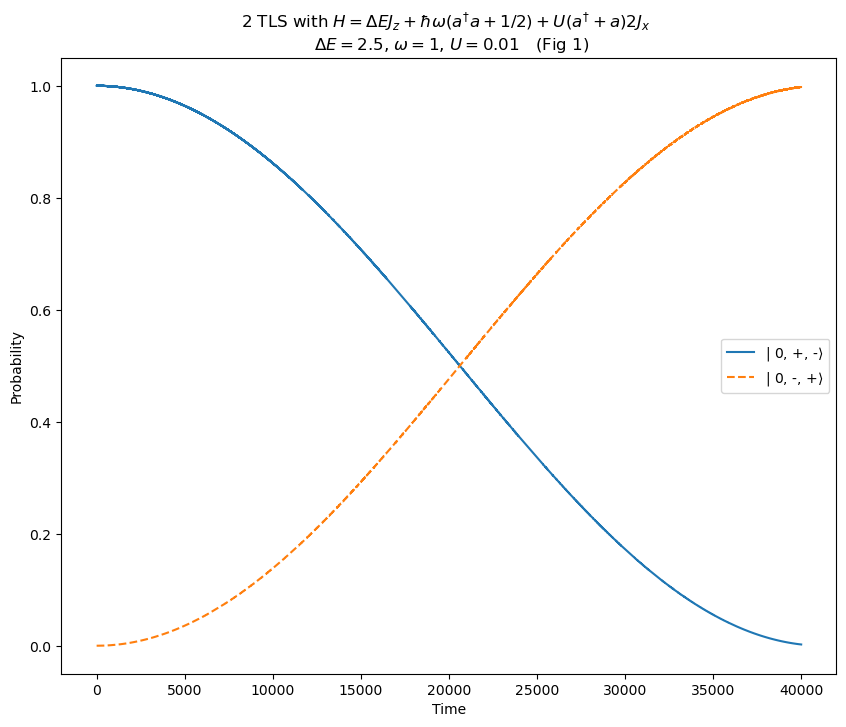

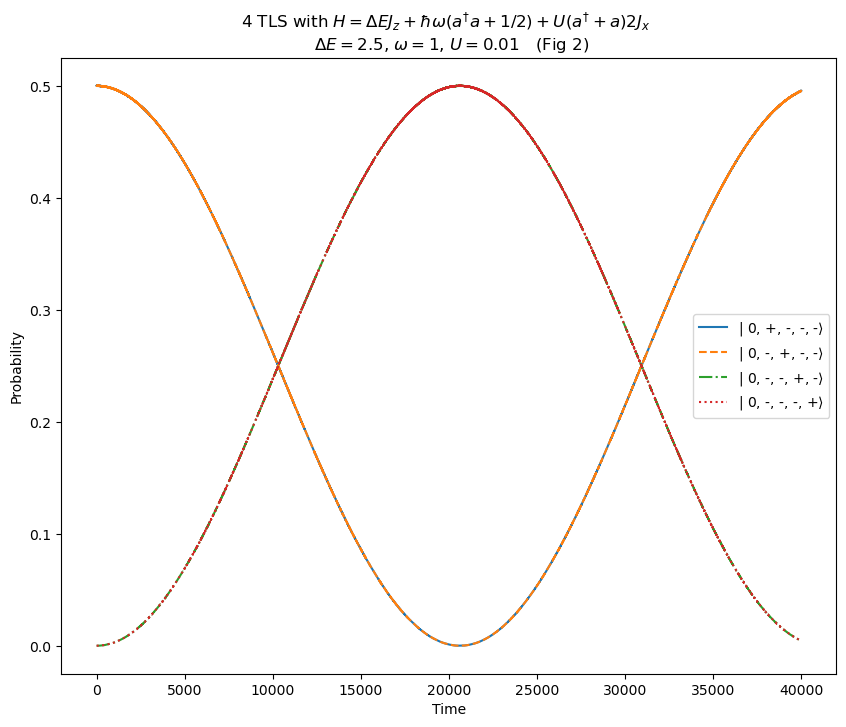

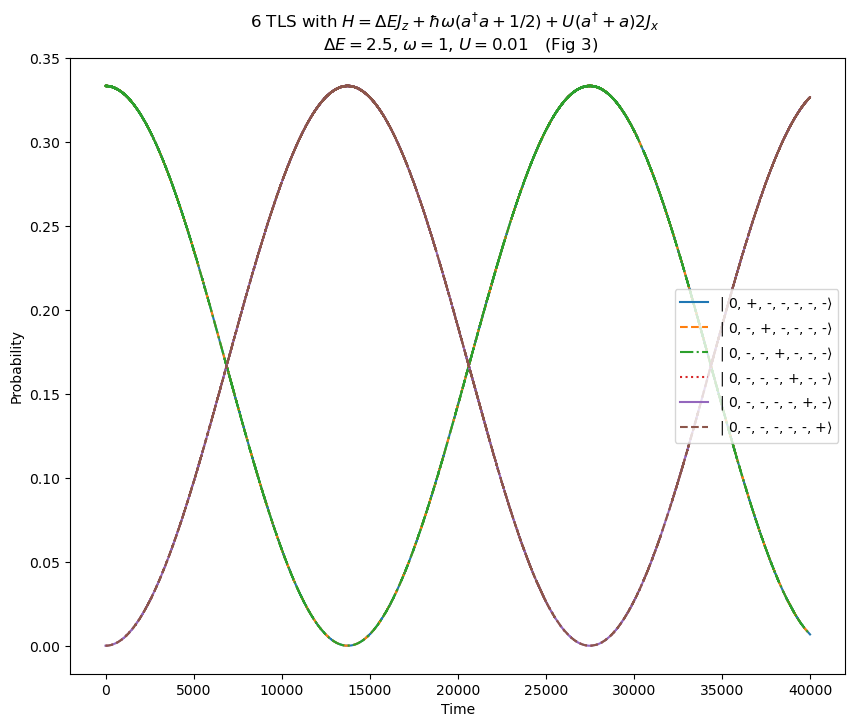

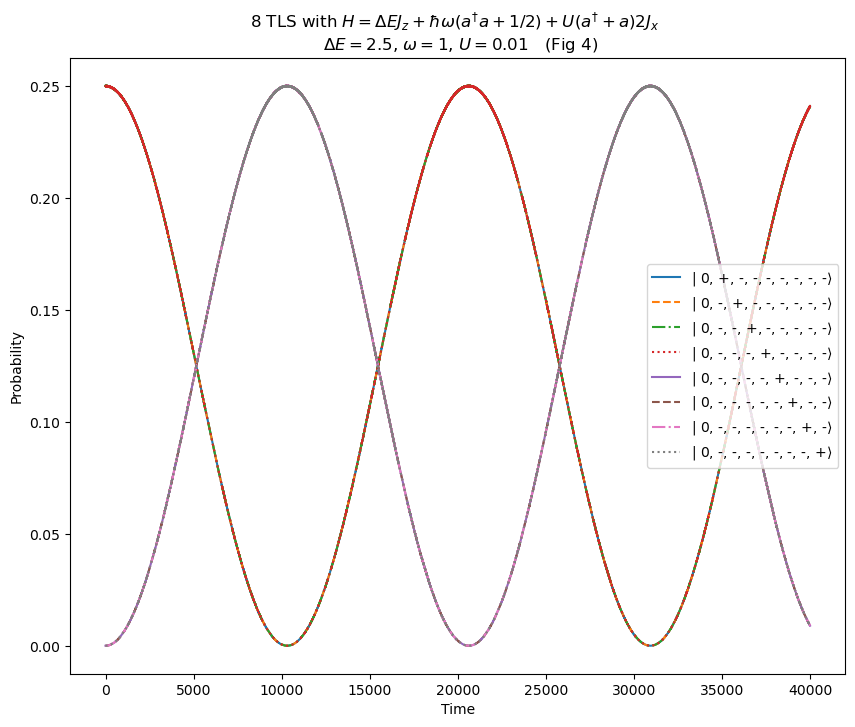

CPU times: user 13min 43s, sys: 13 s, total: 13min 56s
Wall time: 13min 48s


In [7]:
%%time
max_tls_per_group = 4
U=0.01
omega=1
deltaE=2.5

H_latex_AB = "$H = \Delta E J_z + \hbar\omega(a^{{\dagger}}a +1/2) + U( a^{{\dagger}} + a )2J_x$ "


for tls_per_group in range(1,max_tls_per_group+1):
    two_state, bosons, interaction, number, nm_list, J2 = make_operators_J(max_bosons=2,parity=-1,num_TLS=2*tls_per_group)
    H = deltaE*two_state + omega*bosons + U*interaction 
    entangled_state_indices = []
    TLS_B_psi0 = ("-",)*tls_per_group
    psi0 = 0
    for k in range(0,tls_per_group):
        TLS_A_psi0 = ["-",]*tls_per_group
        TLS_A_psi0[k] = "+"
        ind = nm_list.index((0,) + tuple(TLS_A_psi0) + TLS_B_psi0)
        # print(nm_list[ind])
        psi0 += basis(len(nm_list), ind)
    psi0 = psi0.unit()
    
    times = np.linspace(0.0, 40000, 400000)
    P, psi = simulate(H, psi0, times)
    nonzero_P = np.where(np.abs(P.mean(axis=1))>0.01)[0]

    bra_labels, ket_labels = make_braket_labels(nm_list)
    
    plot_prob(P[nonzero_P,:] ,times, [ket_labels[l] for l in nonzero_P])
    plt.title(f"{2*tls_per_group} TLS with {H_latex_AB} \n $\Delta E = {deltaE}$, $\omega={omega}$, $U={U}$   (Fig {tls_per_group})");
    plt.show()  # Display the plot

### 1<sub>A</sub> : N<sub>B</sub>,  1 TLS excited in A

(0, '+', '-')


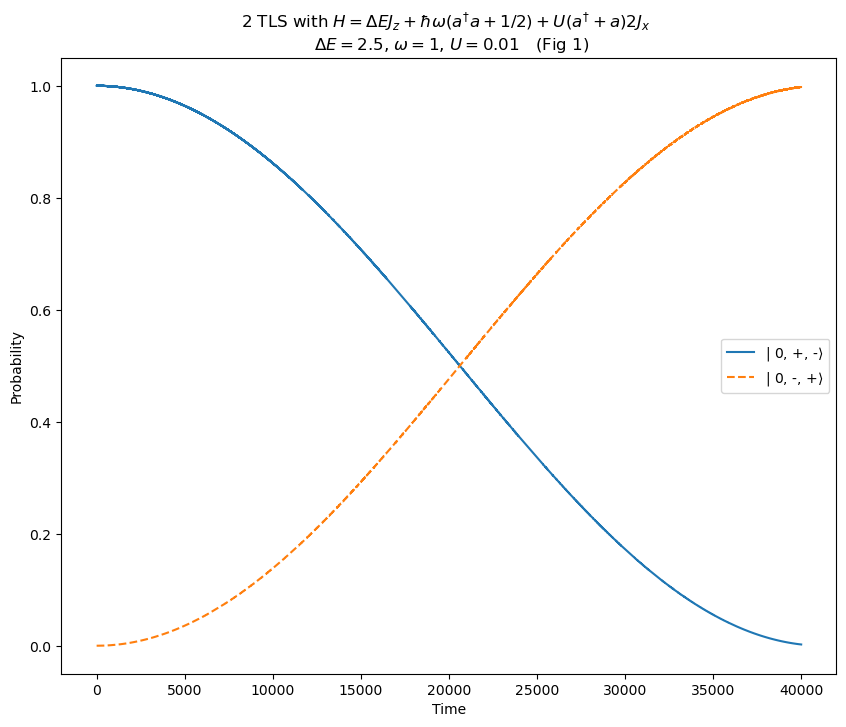

(0, '+', '-', '-', '-')


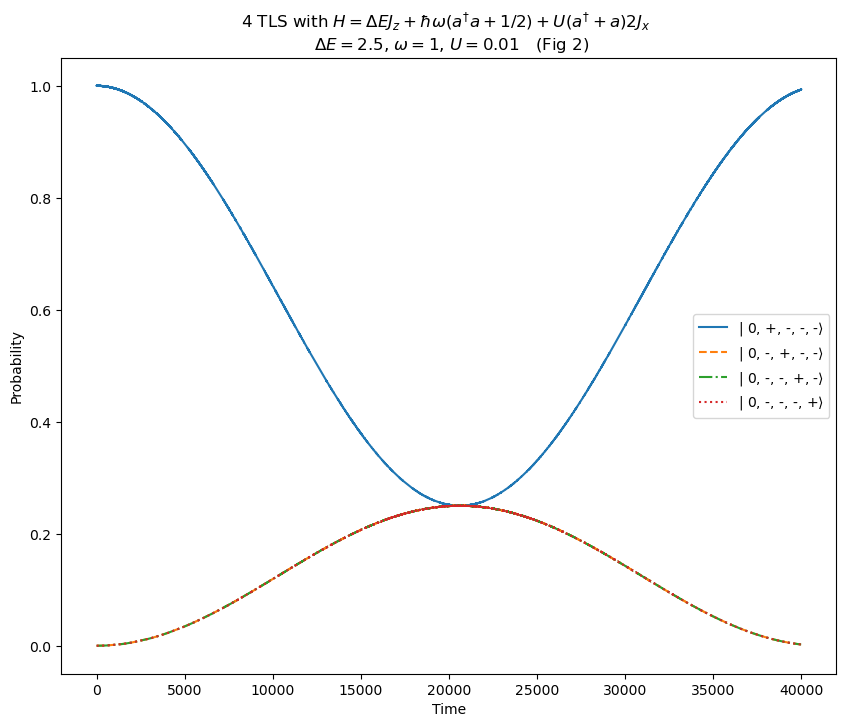

(0, '+', '-', '-', '-', '-', '-')


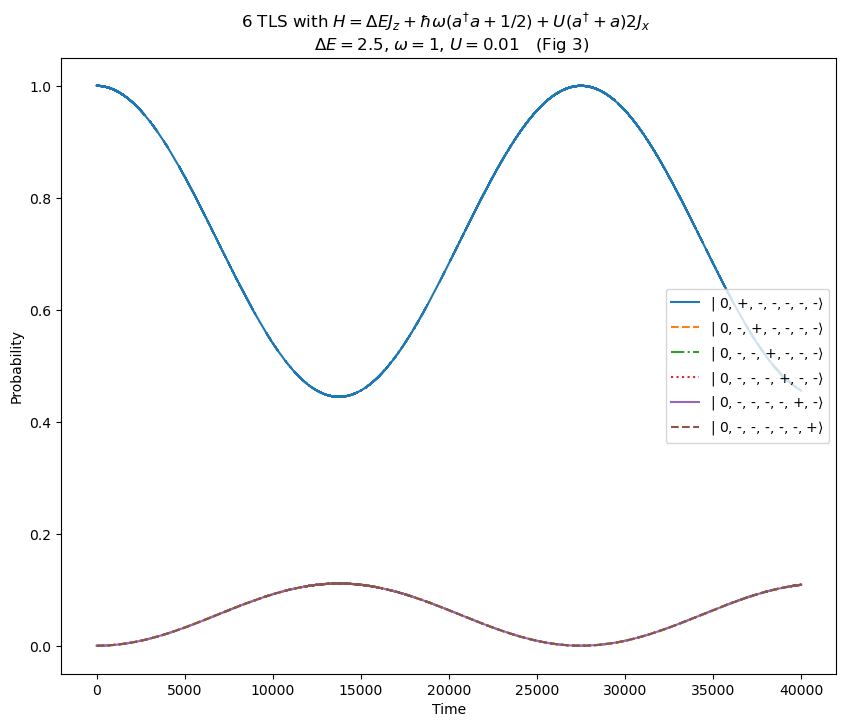

CPU times: user 55.9 s, sys: 3.9 s, total: 59.8 s
Wall time: 55.6 s


In [10]:
%%time
max_tls_per_group = 3
U=0.01
omega=1
deltaE=2.5

H_latex_AB = "$H = \Delta E J_z + \hbar\omega(a^{{\dagger}}a +1/2) + U( a^{{\dagger}} + a )2J_x$ "


for tls_per_group in range(1,max_tls_per_group+1):
    two_state, bosons, interaction, number, nm_list, J2 = make_operators_J(max_bosons=2,parity=-1,num_TLS=2*tls_per_group)
    H = deltaE*two_state + omega*bosons + U*interaction 
    entangled_state_indices = []
    TLS_B_psi0 = ("-",)*tls_per_group
    psi0 = 0
    TLS_A_psi0 = ["-",]*tls_per_group
    TLS_A_psi0[0] = "+"
    ind = nm_list.index((0,) + tuple(TLS_A_psi0) + TLS_B_psi0)
    print(nm_list[ind])
    psi0 += basis(len(nm_list), ind)
    psi0 = psi0.unit()
    
    times = np.linspace(0.0, 40000, 400000)
    P, psi = simulate(H, psi0, times)
    nonzero_P = np.where(np.abs(P.mean(axis=1))>0.01)[0]

    bra_labels, ket_labels = make_braket_labels(nm_list)
    
    plot_prob(P[nonzero_P,:] ,times, [ket_labels[l] for l in nonzero_P])
    plt.title(f"{2*tls_per_group} TLS with {H_latex_AB} \n $\Delta E = {deltaE}$, $\omega={omega}$, $U={U}$   (Fig {tls_per_group})");
    plt.show()  # Display the plot

### N<sub>A</sub> : N<sub>B</sub>,  N/2 TLS excited in A

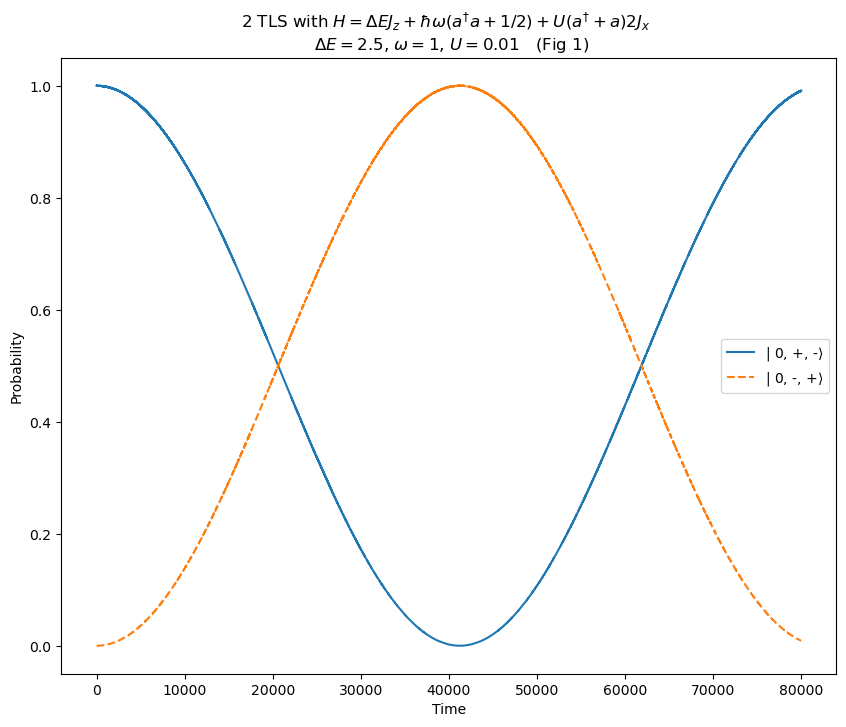

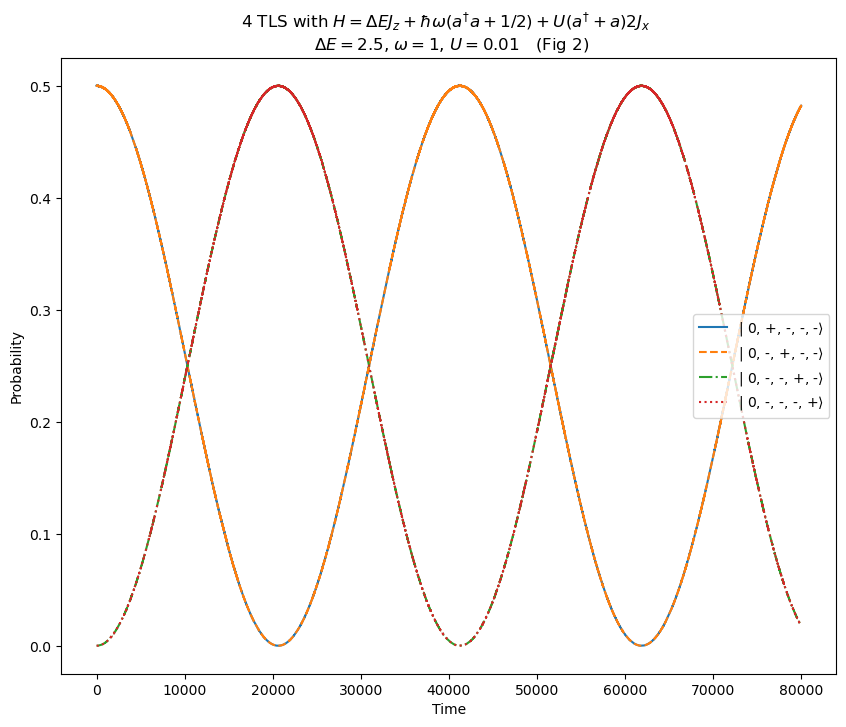

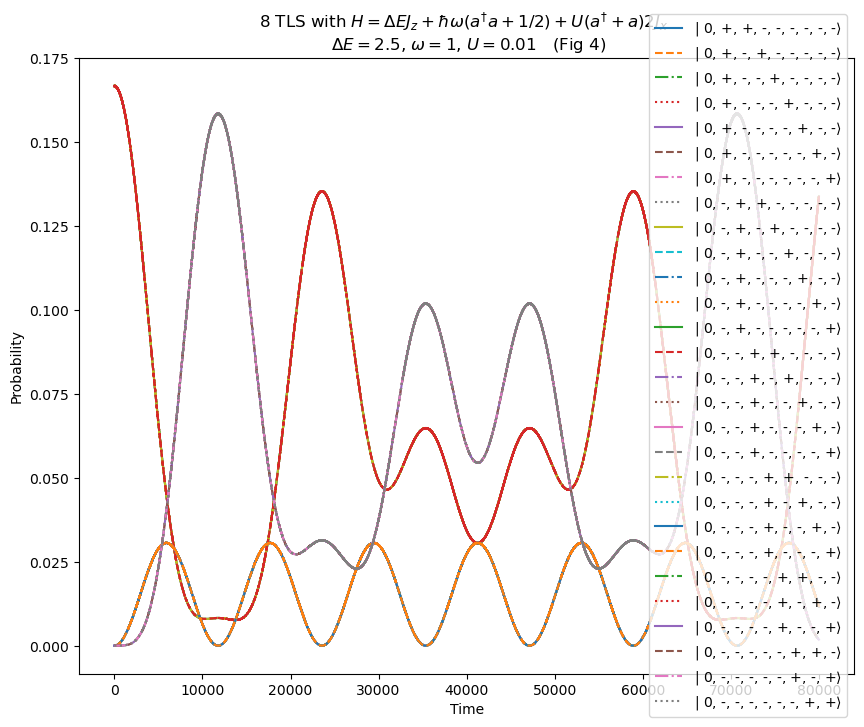

CPU times: user 13min 1s, sys: 28.5 s, total: 13min 29s
Wall time: 13min 24s


In [278]:
%%time
max_tls_per_group = 4
U=0.01
omega=1
deltaE=2.5

H_latex_AB = "$H = \Delta E J_z + \hbar\omega(a^{{\dagger}}a +1/2) + U( a^{{\dagger}} + a )2J_x$ "


for tls_per_group in [1,2,4]:
    if tls_per_group==1:
        parity = -1
    else:
        parity = 1 if tls_per_group//2%2==0 else -1
    two_state, bosons, interaction, number, nm_list, J2 = make_operators_J(max_bosons=2,parity=parity,num_TLS=2*tls_per_group)
    H = deltaE*two_state + omega*bosons + U*interaction 
    entangled_state_indices = []
    TLS_B_psi0 = ("-",)*tls_per_group
    psi0 = 0
    for TLS_A_psi0 in generate_permutations(tls_per_group//2 or 1,tls_per_group//2):
        ind = nm_list.index((0,) + tuple(TLS_A_psi0) + TLS_B_psi0)
        # print(nm_list[ind])
        psi0 += basis(len(nm_list), ind)
    psi0 = psi0.unit()
    
    times = np.linspace(0.0, 80000, 400000)
    P, psi = simulate(H, psi0, times)
    nonzero_P = np.where(np.abs(P.mean(axis=1))>0.001)[0]

    bra_labels, ket_labels = make_braket_labels(nm_list)
    
    plot_prob(P[nonzero_P,:] ,times, [ket_labels[l] for l in nonzero_P])
    plt.title(f"{2*tls_per_group} TLS with {H_latex_AB} \n $\Delta E = {deltaE}$, $\omega={omega}$, $U={U}$   (Fig {tls_per_group})");
    plt.show()  # Display the plot

### Let's try and plot things better

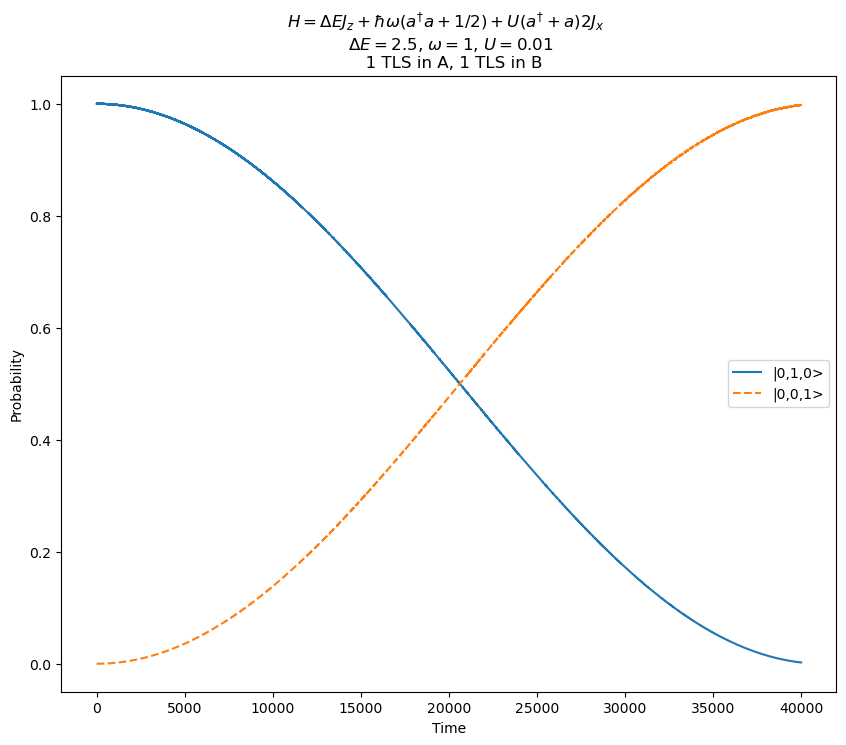

In [260]:
A_ind = []
B_ind = []


for TLS_A_psi0 in generate_permutations(1,tls_per_group//2):
    ind = nm_list.index((0,) + tuple(TLS_A_psi0) + TLS_B_psi0)
    A_ind.append(ind)


for TLS_A_psi0 in generate_permutations(1,tls_per_group//2):
    ind = nm_list.index((0,) + TLS_B_psi0 + tuple(TLS_A_psi0))
    B_ind.append(ind)


plot_prob(np.vstack((P[A_ind,:].sum(axis=0), P[B_ind,:].sum(axis=0))),times,["|0,1,0>","|0,0,1>"])
plt.title(f"{H_latex_AB} \n $\Delta E = {deltaE}$, $\omega={omega}$, $U={U}$ \n  {tls_per_group} TLS in A, {tls_per_group} TLS in B");


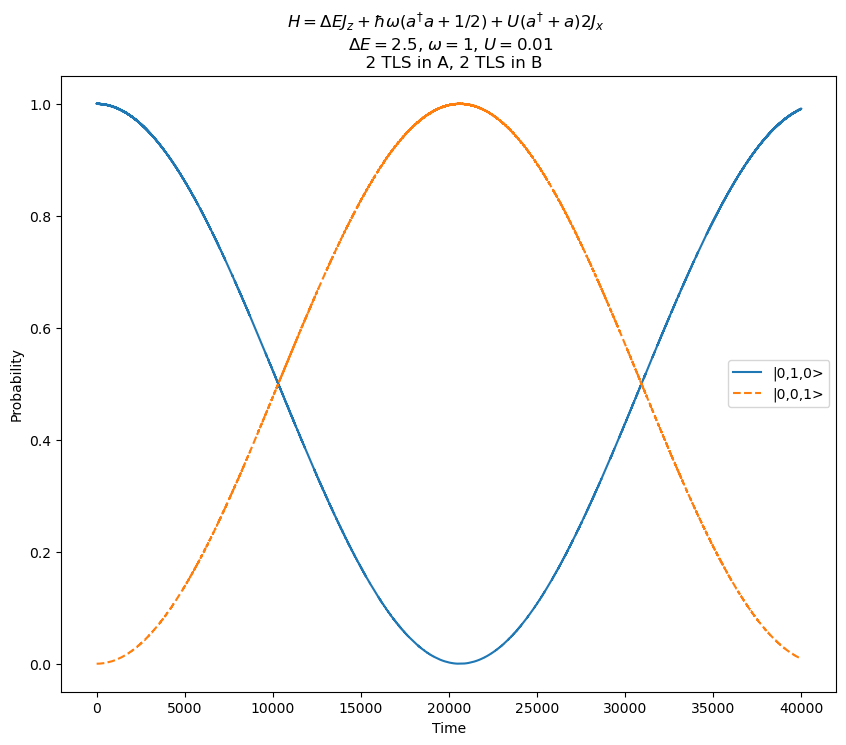

In [257]:
A_ind = []
B_ind = []


for TLS_A_psi0 in generate_permutations(tls_per_group//2,tls_per_group//2):
    ind = nm_list.index((0,) + tuple(TLS_A_psi0) + TLS_B_psi0)
    A_ind.append(ind)


for TLS_A_psi0 in generate_permutations(tls_per_group//2,tls_per_group//2):
    ind = nm_list.index((0,) + TLS_B_psi0 + tuple(TLS_A_psi0))
    B_ind.append(ind)


plot_prob(np.vstack((P[A_ind,:].sum(axis=0), P[B_ind,:].sum(axis=0))),times,["|0,1,0>","|0,0,1>"])
plt.title(f"{H_latex_AB} \n $\Delta E = {deltaE}$, $\omega={omega}$, $U={U}$ \n  {tls_per_group} TLS in A, {tls_per_group} TLS in B");


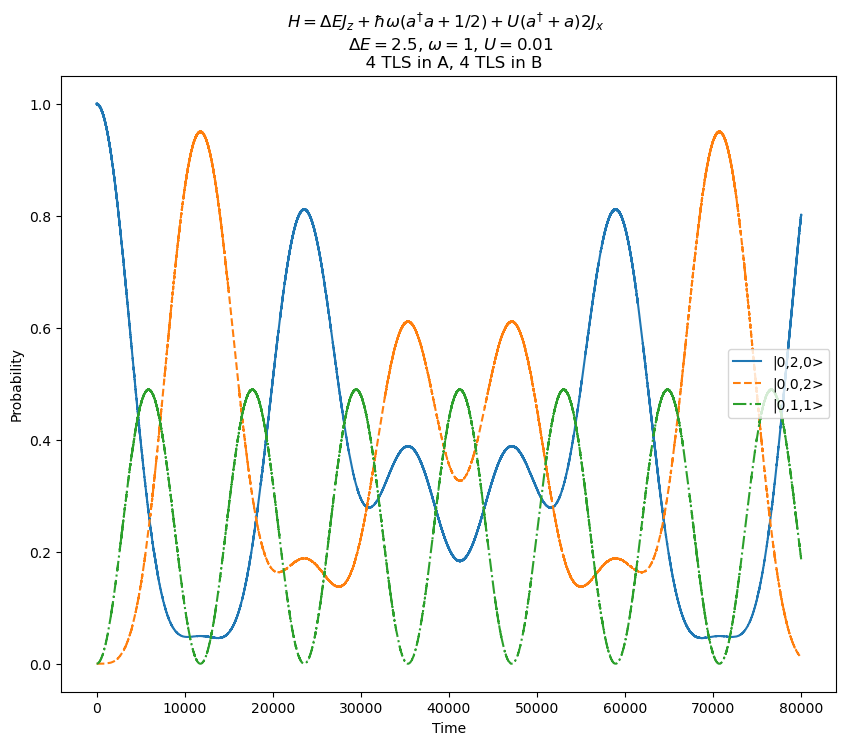

In [279]:
A_ind = []
B_ind = []
AB = []


for TLS_A_psi0 in generate_permutations(tls_per_group//2,tls_per_group//2):
    ind = nm_list.index((0,) + tuple(TLS_A_psi0) + TLS_B_psi0)
    A_ind.append(ind)


for TLS_A_psi0 in generate_permutations(tls_per_group//2,tls_per_group//2):
    ind = nm_list.index((0,) + TLS_B_psi0 + tuple(TLS_A_psi0))
    B_ind.append(ind)

AB_ind = [x for x in nonzero_P if x not in A_ind+B_ind]

plot_prob(np.vstack((P[A_ind,:].sum(axis=0), P[B_ind,:].sum(axis=0), P[AB_ind,:].sum(axis=0))),times,["|0,2,0>","|0,0,2>","|0,1,1>"])
plt.title(f"{H_latex_AB} \n $\Delta E = {deltaE}$, $\omega={omega}$, $U={U}$ \n  {tls_per_group} TLS in A, {tls_per_group} TLS in B");


## Separate the systems A and B properly

In [181]:
def make_operators_JAB(max_bosons, parity=0, num_TLS=1):
    
    a     = tensor([destroy(max_bosons+1)] + [qeye(2) for i in range(1,num_TLS+1)] + [qeye(2) for i in range(1,num_TLS+1)])      # tensorised boson destruction operator
    JA     = jspin(num_TLS, basis="uncoupled")
    JB     = jspin(num_TLS, basis="uncoupled")
    JxA    = tensor([qeye(max_bosons+1)] + [JA[0]] + [qeye(2) for i in range(1,num_TLS+1)])                                             # tensorised Jx operator
    JzA    = tensor([qeye(max_bosons+1)] + [JA[2]] + [qeye(2) for i in range(1,num_TLS+1)])   # tensorised Jx operator
    J2A    = tensor([qeye(max_bosons+1)] + [JA[0]*JA[0] + JA[1]*JA[1] + JA[2]*JA[2]] + [qeye(2) for i in range(1,num_TLS+1)])                # tensorised J^2 operator
    JxB    = tensor([qeye(max_bosons+1)] + [qeye(2) for i in range(1,num_TLS+1)] + [JB[0]])                                             # tensorised Jx operator
    JzB    = tensor([qeye(max_bosons+1)] + [qeye(2) for i in range(1,num_TLS+1)] + [JB[2]])   
    J2B    = tensor([qeye(max_bosons+1)] + [qeye(2) for i in range(1,num_TLS+1)] + [JB[0]*JB[0] + JB[1]*JB[1] + JB[2]*JB[2]])                 # tensorised J^2 operator

    two_state_A     = JzA                                 # two state system energy operator   Jz
    two_state_B     = JzB                                 # two state system energy operator   Jz
    bosons        = (a.dag()*a+0.5)                    # boson energy operator              𝑎†𝑎+1/2
    number        = a.dag()*a                          # boson number operator              𝑎†𝑎
    interaction_A   = 2*(a.dag() + a) * JxA               # interaction energy operator        2(𝑎†+𝑎)Jz  
    interaction_B   = 2*(a.dag() + a) * JxB               # interaction energy operator        2(𝑎†+𝑎)Jz  
    
    P = (1j*np.pi*(number + JzA + JzB + num_TLS)).expm()               # parity operator 
    
    # map from QuTiP number states to |n,±, ±, ...> states
    possible_ns = range(0, max_bosons+1)
    possible_ms = ["+","-"]
    nm_list = [(n, *ms) for n in possible_ns for ms in product(possible_ms, repeat=num_TLS*2)]
    # nm_list = [(n,m1,m2,m3,m4) for (n,m1,m2,m3,m4) in product(possible_ns, possible_ms, possible_ms,possible_ms,possible_ms)]

    
    # only do parity extraction if a valid parity is being used
    if (parity==1) | (parity==-1):
        p               = np.where(P.diag()==parity)[0]
        
        two_state_A       = two_state.extract_states(p)
        two_state_B       = two_state.extract_states(p)
        bosons          = bosons.extract_states(p)
        number          = number.extract_states(p)
        interaction_A     = interaction_A.extract_states(p)
        interaction_B     = interaction_B.extract_states(p)
        nm_list        = [nm_list[i] for i in p]
  
    
    return two_state_A, two_state_B, bosons, interaction_A, interaction_B, number, nm_list, P

### N<sub>A</sub> : N<sub>B</sub>,  1 TLS excited in A

1


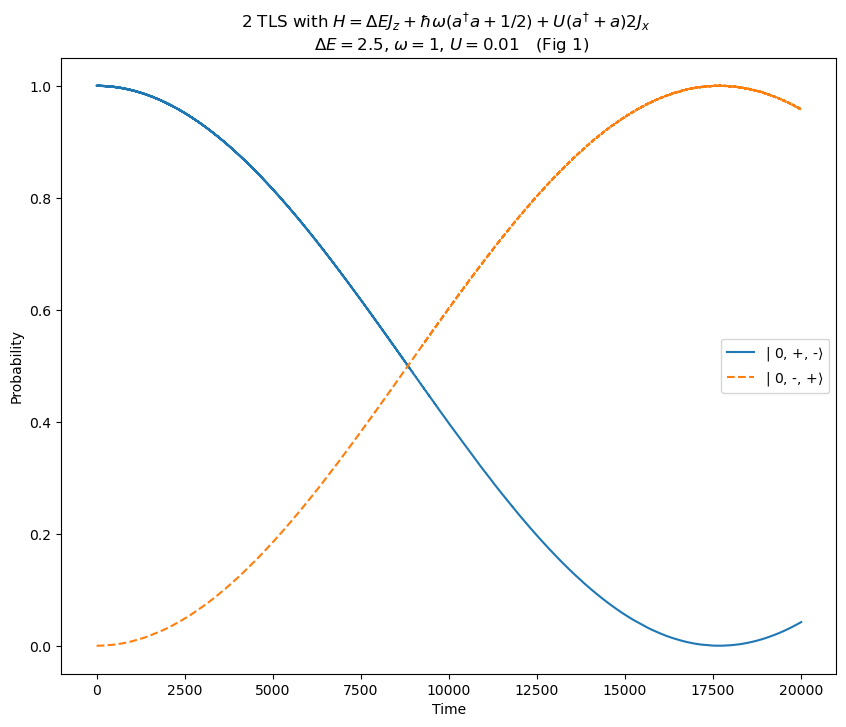

2


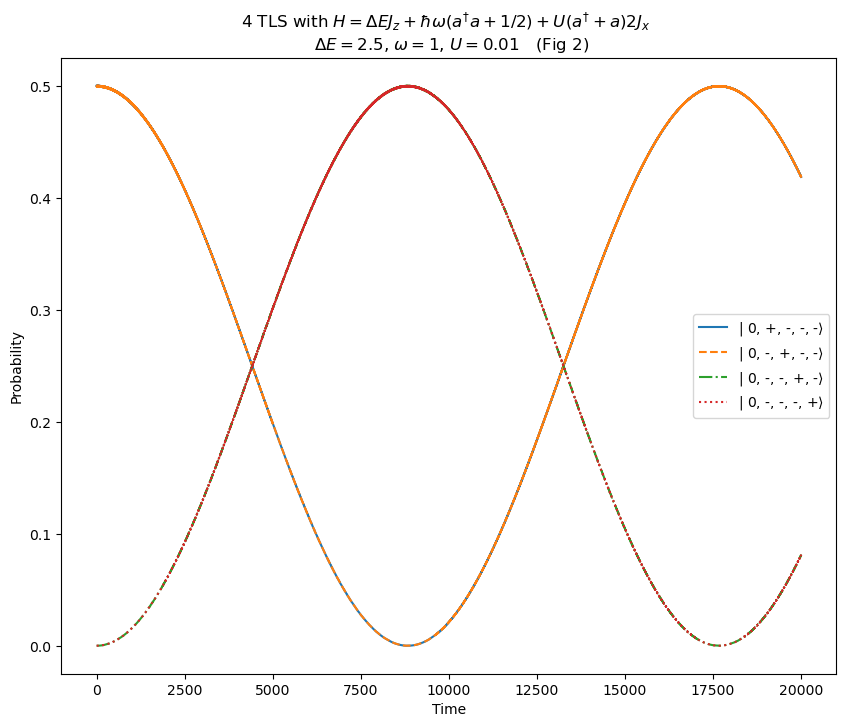

3


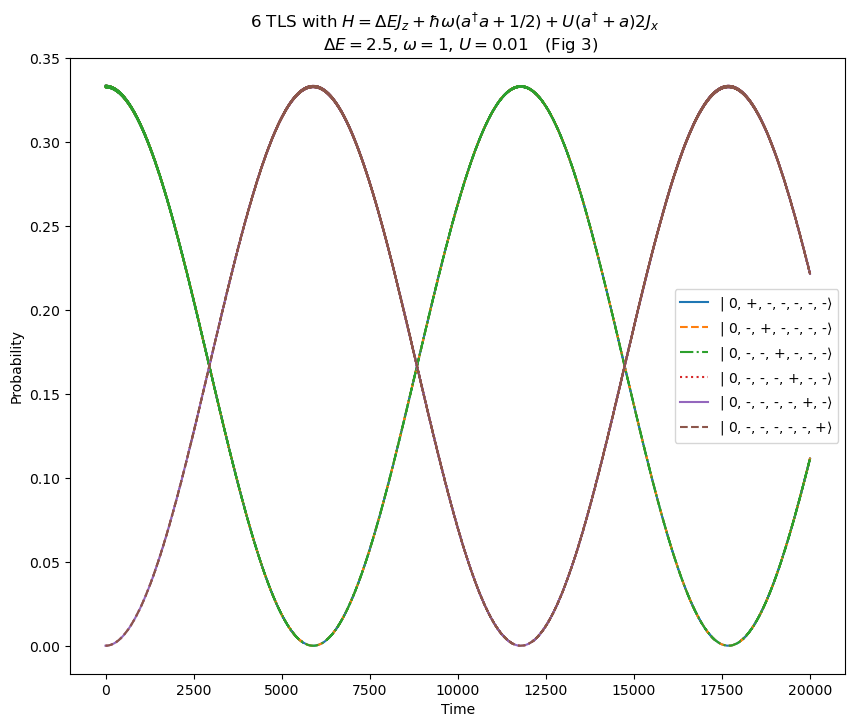

CPU times: user 29.3 s, sys: 1.56 s, total: 30.9 s
Wall time: 26.3 s


In [180]:
%%time
max_tls_per_group = 3
U=0.01
omega=1
deltaE=2.5

H_latex_AB = "$H = \Delta E J_z + \hbar\omega(a^{{\dagger}}a +1/2) + U( a^{{\dagger}} + a )2J_x$ "


for tls_per_group in range(1,max_tls_per_group+1):
    two_state_A, two_state_B, bosons, interaction_A, interaction_B,  number, nm_list = make_operators_JAB(max_bosons=2,parity=-1,num_TLS=tls_per_group)
    H = deltaE*(two_state_A + two_state_B) + omega*bosons + U*(interaction_A +  interaction_B)
    entangled_state_indices = []
    TLS_B_psi0 = ("-",)*tls_per_group
    psi0 = 0
    for TLS_A_psi0 in generate_permutations(1,tls_per_group-1):
        ind = nm_list.index((0,) + tuple(TLS_A_psi0) + TLS_B_psi0)
        # print(nm_list[ind])
        psi0 += basis(len(nm_list), ind)
    psi0 = psi0.unit()
    
    times = np.linspace(0.0, 20000, 200000)
    P, psi = simulate(H, psi0, times)
    nonzero_P = np.where(np.abs(P.mean(axis=1))>0.01)[0]

    bra_labels, ket_labels = make_braket_labels(nm_list)
    
    plot_prob(P[nonzero_P,:] ,times, [ket_labels[l] for l in nonzero_P])
    plt.title(f"{2*tls_per_group} TLS with {H_latex_AB} \n $\Delta E = {deltaE}$, $\omega={omega}$, $U={U}$   (Fig {tls_per_group})");
    plt.show()  # Display the plot